In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
path = 'data.csv'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv(path)
# в 4м дз нам не нужна колонка campaign_clicks
data.drop(["campaign_clicks"], axis=1, inplace=True)
data.head()

,date_time,zone_id,banner_id,oaid_hash,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


In [4]:
def analysis(data: pd.DataFrame):
    # проверим, есть ли null значения
    count_null = data.isnull().sum().sum()
    print('Количетво null значений =', count_null)
    # посмотрим на уникальные значения для каждой фичи и для изучения распределения построим гистограмму
    features = ['os_id', 'country_id', 'banner_id', 'zone_id', 'impressions']
    for feature in features:
        uniq_vals = data[feature].nunique()
        print(f"Количество уникальных значений для {feature}:  {uniq_vals}")
        plt.hist(data[feature], bins=min(50,uniq_vals))
        plt.show()
   # на какие-то характеристик даты посмотрим отдельно
    data['date_time'] = pd.to_datetime(data['date_time'])
    data_time = data.copy()
    data_time['date'] = data['date_time'].dt.date
    print(data_time['date'].value_counts())
    # также посмотрим как устроены g_0 и g_1
    count_g0_neg = len(data[data['g0'] < 0])
    count_g1_neg = len(data[data['g1'] < 0])
    print("Negative g0", count_g0_neg)
    print("Negative g1", count_g1_neg)


Количетво null значений = 59439
Количество уникальных значений для os_id:  11


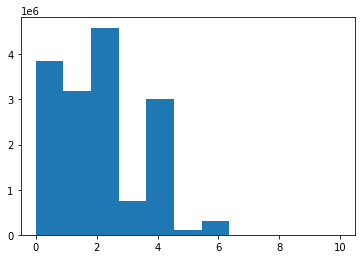

Количество уникальных значений для country_id:  17


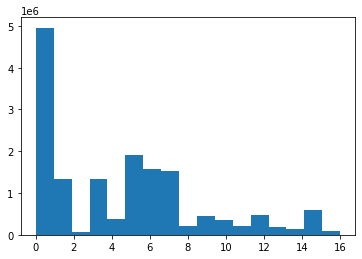

Количество уникальных значений для banner_id:  1633


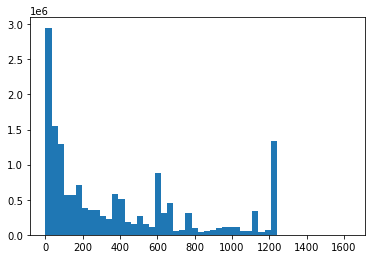

Количество уникальных значений для zone_id:  3444


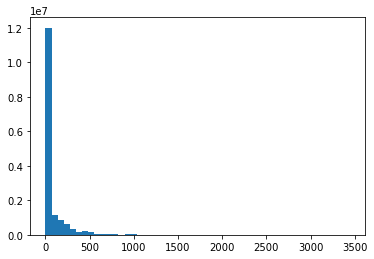

Количество уникальных значений для impressions:  1


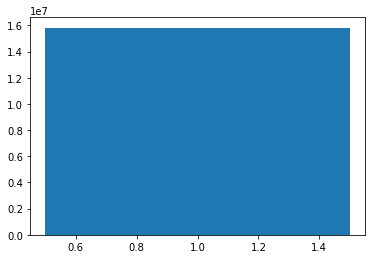

2021-09-26    3102610
2021-09-29    2420588
2021-09-27    2367303
2021-09-28    2307355
2021-10-02    2128978
2021-09-30    1851189
2021-10-01    1643448
2021-09-01          1
Name: date, dtype: int64
Negative g0 5
Negative g1 5


In [5]:
analysis(data)

Можно сделать следующие наблюдения: 
1) null значения есть => вычистим их \
2) impressions не несет никакой полезной информации, т.к. все значения в нем равны 1 => удалим \
3) Дат не так много и видно, что все кроме одной (2021-09-01) идут последовательно друг за другом, в эту же "странную" дату попало всего 1 значение, очень похоже на выброс, поэтому уберем эту дату \
4) Из даты больше всего информации несут часы (можно было бы еще разделить сутки на части, но я думаю, это не существенно), т.к. временные данные представлены узким временным отрезком (неделя или чуть больше) \
5) Отрицательные g_0 и g_1 удалим

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [7]:
print(data.head())

            date_time  zone_id  banner_id            oaid_hash  os_id  \
0 2021-09-27 00:01:30        0          0  5664530014561852622      0   
1 2021-09-26 22:54:49        1          1  5186611064559013950      0   
2 2021-09-26 23:57:20        2          2  2215519569292448030      0   
3 2021-09-27 00:04:30        3          3  6262169206735077204      1   
4 2021-09-27 00:06:21        4          4  4778985830203613115      1   

   country_id  banner_id0  rate0        g0  coeff_sum0  banner_id1  rate1  \
0           0        1240  0.067  0.035016   -7.268846           0  0.010   
1           1           1  0.002  0.054298   -2.657477         269  0.004   
2           0           2  0.014  0.014096   -3.824875          21  0.014   
3           1           3  0.012  0.015232   -3.461357          99  0.006   
4           0           4  0.019  0.051265   -4.009026    11464230  6.790   

         g1  coeff_sum1  impressions  clicks  
0  0.049516   -5.369901            1       1  
1  0

In [8]:
from scipy import sparse

In [9]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # чистим данные в соответствии с выводами выше
    data['date_time'] = pd.to_datetime(data['date_time'])
    data = data.drop(['impressions', 'oaid_hash', 'rate0', 'rate1'], axis=1)
    data = data[data['date_time'] > '2021-09-02']
    data['hour'] = data['date_time'].dt.hour
    data = data[(data['g1'] > 0) & (data['g0'] > 0)]
    # фильтруем случаи когда banner_id0 не совпадает с banner_id
    data = data[data['banner_id0'] == data['banner_id']]
    data = data.drop(['banner_id0'], axis=1)
    data = data.dropna()
    
    # у нас есть категориальные фичи
    # date_time сам по себе не несет какой-то информации,
    # поэтому этой колонки и нет в итоговых фичах, вместо нее - часы 
    not_use = ['g0', 'g1', 'coeff_sum0','coeff_sum1', 'clicks','date_time', 'banner_id1']

    # делаем разбиение на трейн и тест: берем в тест последний день
    train = data[data['date_time'] < '2021-10-02']
    test = data[data['date_time'] >='2021-10-02']
    y_train = train['clicks']
    y_test = test['clicks']
    X_train = train.drop(not_use, axis=1, inplace=False)
    X_test = test.drop(not_use, axis=1, inplace=False)
    # делаем ван хот энкодинг категориальных фичей
    enc = OneHotEncoder(handle_unknown='ignore')
    X_train = enc.fit_transform(X_train)
    X_test = enc.transform(X_test)
    
    dists = test[['g0', 'g1', 'coeff_sum0', 'coeff_sum1']]
    not_use_test = ['g0', 'g1', 'coeff_sum0','coeff_sum1', 'clicks','date_time']
    test = test.drop(not_use_test, axis=1)
    
    # p_0
    X_test_p0 = test.drop(['banner_id1'], axis=1, inplace=False)
    X_test_p0 = enc.transform(X_test_p0)
    
    # p_1
    test['banner_id'] = test['banner_id1']
    X_test_p1 = test.drop(['banner_id1'], axis=1)
    X_test_p1 = enc.transform(X_test_p1)

    return X_train, y_train, X_test_p0, X_test_p1, y_test, dists

In [10]:
X_train, y_train, X_test_p0, X_test_p1, y_test, dist = feature_engineering(data)

In [11]:
from sklearn.linear_model import LogisticRegression


In [12]:
# создаем модель, берем логистическую регрессию: оптимизатор liblinear - не SGD like + обсуждалась на лекции, поэтому взяла его
# состояние фиксируем для воспроизводимости 
def create_model(C=0.1):
    model = LogisticRegression(solver='liblinear', C=C, penalty='l2', random_state=42)
    return model

In [13]:
best_C = 0.01

In [14]:
from sklearn.metrics import log_loss, roc_auc_score

In [15]:
# обучим модель с лучшим коэффициентом регуляризации
model = create_model(best_C)
model.fit(X_train, y_train)
y_pred = model.predict(X_test_p0)
auc = roc_auc_score(y_test, model.predict_proba(X_test_p0)[:, 1])
logloss = log_loss(y_test, model.predict_proba(X_test_p0))
print('Auc roc = ', auc,'   logloss = ', logloss)

# сравним с бейзлайном: предикт среднего по выборке
y_pred_baseline = np.full(y_pred.shape, np.mean(y_train))
auc_baseline = roc_auc_score(y_test, y_pred_baseline)
logloss_baseline = log_loss(y_test, y_pred_baseline)
print('Auc roc = ', auc_baseline,'   logloss = ', logloss_baseline)

Auc roc =  0.7908809263721724    logloss =  0.13438044371298458
Auc roc =  0.5    logloss =  0.15807389941939862


In [16]:
from scipy.special import logit
from scipy.stats import norm

In [17]:
# Предсказания
p_0 = model.predict_proba(X_test_p0)[:, 1]
p_1 = model.predict_proba(X_test_p1)[:, 1]

In [18]:
def calc_pi(coeff_sum0, coeff_sum1, g0, g1):
    return 1. - norm.cdf(0., loc=coeff_sum0 - coeff_sum1, scale=np.sqrt(g0 ** 2 + g1 ** 2) + 1e-6)

In [19]:
pi_0 = calc_pi(dist['coeff_sum0'], dist['coeff_sum1'],dist['g0'], dist['g1'])
pi_1 = calc_pi(logit(p_0), logit(p_1),dist['g0'], dist['g1'])

In [20]:
print(pi_0)

[1.00000000e+00 1.00000000e+00 8.23530133e-11 ... 0.00000000e+00
 4.84896323e-01 4.95142993e-01]


In [25]:
lam = 10

In [27]:
cips = np.mean(y_test * np.clip(pi_1 / (pi_0 + 1e-10), None, lam))
print(cips)

0.06660482430264841


Выкладки:
$$ X \sim N(coef_0, g0^2)$$
$$ Y \sim N(coef_1, g1^2)$$
$$P(X > Y) = 1 - P(X - Y < 0) = 1 - F_{X-Y}(0)$$

